In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryF1Score

from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

c:\Users\PNC\anaconda3\envs\Project_38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = './Data/'

train_df = pd.read_csv(DATA_PATH + 'train.csv')
test_df = pd.read_csv(DATA_PATH + 'test.csv')
submission_df = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [3]:
train_df.head(30)

,ID,URL,label
0,TRAIN_0000000,poznan[.]wuoz[.]gov[.]pl,0
1,TRAIN_0000001,vill[.]okawa[.]kochi[.]jp,0
2,TRAIN_0000002,nationalfinance[.]co[.]om,0
3,TRAIN_0000003,town[.]ozora[.]hokkaido[.]jp,0
4,TRAIN_0000004,open24[.]ie-news[.]irish/online/Login,1
5,TRAIN_0000005,93fm[.]radio[.]br/file,1
6,TRAIN_0000006,ps[.]com[.]vu/wp-config/wp-incluides/soft/ursn...,1
7,TRAIN_0000007,rih[.]p[.]se,0
8,TRAIN_0000008,microsoft[.]ltda,0
9,TRAIN_0000009,165[.]232[.]173[.]145/mobile[.]html,1


In [4]:
test_df.head()

,ID,URL
0,TEST_0000000,niquelarte[.]blogspot[.]com[.]es
1,TEST_0000001,northernmetalproducts[.]com
2,TEST_0000002,ga[.]de
3,TEST_0000003,florawww[.]eeb[.]uconn[.]edu/199300089[.]html
4,TEST_0000004,activecity[.]moscow


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6995056 entries, 0 to 6995055
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   ID      object
 1   URL     object
 2   label   int64 
dtypes: int64(1), object(2)
memory usage: 160.1+ MB


In [6]:
train_df[train_df['URL'].isna()]

,ID,URL,label


In [7]:
train_df[train_df['label'].isna()]

,ID,URL,label


C:\Users\PNC\AppData\Local\Temp\ipykernel_16388\1986079669.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = train_df['label'].value_counts().index,


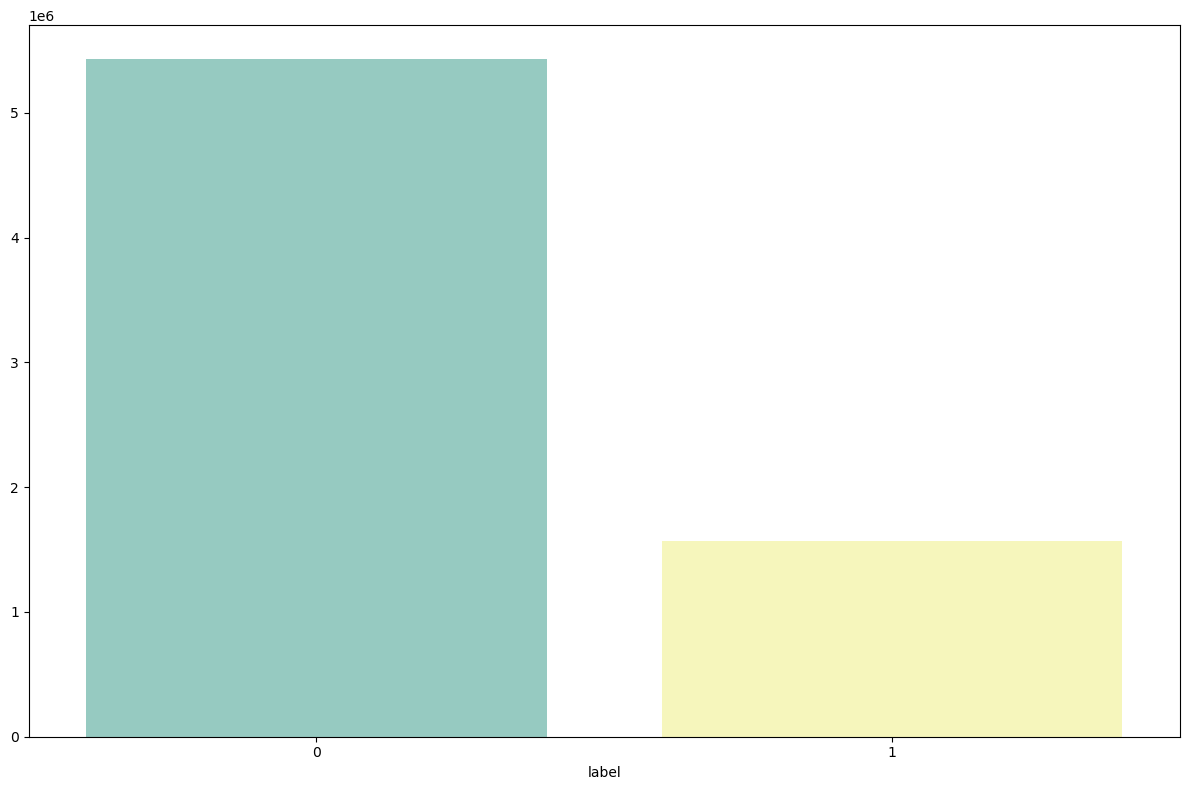

In [8]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.barplot(x = train_df['label'].value_counts().index,
            y = train_df['label'].value_counts().values,
            palette = 'Set3',
            ax = ax)
plt.tight_layout()
plt.show()

In [9]:
train_df[train_df['label'] == 1]

,ID,URL,label
4,TRAIN_0000004,open24[.]ie-news[.]irish/online/Login,1
5,TRAIN_0000005,93fm[.]radio[.]br/file,1
6,TRAIN_0000006,ps[.]com[.]vu/wp-config/wp-incluides/soft/ursn...,1
9,TRAIN_0000009,165[.]232[.]173[.]145/mobile[.]html,1
12,TRAIN_0000012,apollo[.]baby,1
...,...,...,...
6995033,TRAIN_6995033,posts-8012419782[.]smarttechno[.]hr,1
6995044,TRAIN_6995044,rthe[.]top/,1
6995047,TRAIN_6995047,www2[.]ml[.]meiceaord[.]com,1
6995050,TRAIN_6995050,10rtggdoffice[.]duckdns[.]org,1


In [10]:
train_df['URL'] = train_df['URL'].apply(lambda x: x.replace('[.]', '.'))
test_df['URL'] = test_df['URL'].apply(lambda x: x.replace('[.]', '.'))

In [11]:
def tokenize_url(url):
    tokens = re.split(r'[\W_]+', url)
    return [t.lower() for t in tokens if t and t not in ["www", "com", "http", "https"]]

train_url = train_df['URL']
train_url = [tokenize_url(url) for url in train_url]

test_url = test_df['URL']
test_url = [tokenize_url(url) for url in test_url]

train_url

[['poznan', 'wuoz', 'gov', 'pl'],
 ['vill', 'okawa', 'kochi', 'jp'],
 ['nationalfinance', 'co', 'om'],
 ['town', 'ozora', 'hokkaido', 'jp'],
 ['open24', 'ie', 'news', 'irish', 'online', 'login'],
 ['93fm', 'radio', 'br', 'file'],
 ['ps', 'vu', 'wp', 'config', 'wp', 'incluides', 'soft', 'ursnbxmmvd'],
 ['rih', 'p', 'se'],
 ['microsoft', 'ltda'],
 ['165', '232', '173', '145', 'mobile', 'html'],
 ['vanylven', 'no'],
 ['pref', 'kagawa', 'jp'],
 ['apollo', 'baby'],
 ['adonis', 'holdings'],
 ['jalawave', 'net', 'id'],
 ['hiroshima', 'jp'],
 ['town', 'hiroo', 'hokkaido', 'jp'],
 ['nic', 'weather'],
 ['nsa', 'community'],
 ['allegro', 'tm', 'pl'],
 ['championsleague', 'basketball'],
 ['cmsjm', 'rj', 'gov', 'br'],
 ['wcape', 'school', 'za'],
 ['town', 'yugawara', 'kanagawa', 'jp'],
 ['global', 'net', 'pg', 'diocese', 'of', 'aitape', 'aitape', 'htm'],
 ['vill', 'ogimi', 'okinawa', 'jp'],
 ['oldham', 'sch', 'uk'],
 ['city', 'makinohara', 'shizuoka', 'jp'],
 ['kagoshima', 'jp'],
 ['vill', 'sekikaw

In [12]:
def url_to_vector(url, model):
    vectors = [model.wv[token] for token in url if token in model.wv]  # Word2Vec에서 벡터 찾기
    if vectors:
        return np.mean(vectors, axis = 0)  # 여러 단어의 평균 벡터
    else:
        return np.zeros(model.vector_size)  # 단어가 없으면 0 벡터 반환


In [13]:
word2vec_model = Word2Vec(sentences = train_url, vector_size = 100, window = 5, min_count = 1, sg = 1, workers = 5)

train_url = [url_to_vector(url, word2vec_model) for url in train_url]  # Train 데이터를 벡터로 변환
test_url = [url_to_vector(url, word2vec_model) for url in test_url]




In [14]:
train_url

[array([-0.5556482 ,  1.1536453 , -0.07721481,  1.5030484 ,  0.44220725,
        -0.11614794,  0.594375  ,  0.49486023,  0.99266696, -0.5969256 ,
        -0.25960776, -0.05716762,  1.0038605 ,  0.4202225 ,  1.2621303 ,
        -0.01872307,  1.2809304 , -0.9889172 ,  0.6134518 , -1.9422414 ,
         1.3540611 ,  0.08947504, -0.36975235, -0.63809246,  0.395079  ,
         1.4178189 , -1.2055117 , -0.4160354 , -0.5847761 ,  0.42200583,
         0.6892872 , -0.07589065,  0.6356821 , -2.1166904 , -0.03343628,
        -0.04869521, -0.6191968 ,  1.1185617 ,  1.0860956 , -1.1638638 ,
        -0.31879163, -0.10741013,  1.8715149 , -0.36768025,  0.99906963,
        -1.7273633 , -0.12775369, -0.96490234,  0.10189962,  1.0364949 ,
         0.5112396 ,  0.14837271, -2.068358  ,  1.3913385 ,  0.28385895,
         1.4095943 ,  1.3758609 ,  0.16308647, -0.1821858 , -0.12872347,
         0.27913952, -0.1153791 ,  1.2361035 ,  2.1959107 , -0.49906284,
         0.5205711 , -0.3469807 ,  0.9433287 ,  0.9

In [15]:
class TextDataset(Dataset):
    def __init__(self, df):
        self.url = df["URL"].values 
        self.label = df["label"].values

    def __len__(self):
        return len(self.url)
    
    def __getitem__(self, index):
        return (torch.tensor(self.url[index], dtype = torch.float),
                torch.tensor(self.label[index], dtype = torch.long))

In [16]:
train_df = train_df.drop('ID', axis = 1)
test_df = test_df.drop('ID', axis = 1)



In [17]:
train_df['URL'] = train_url
test_df['URL'] = test_url

In [18]:
train_df['URL']

0          [-0.5556482, 1.1536453, -0.07721481, 1.5030484...
1          [-1.3871384, -0.0074526146, -0.8648665, 0.2644...
2          [-1.2878505, 0.32698807, 0.028637806, 0.066161...
3          [-1.6598256, 0.33844653, -1.2768847, 0.4935698...
4          [-1.3288579, -0.20952149, -0.6103649, -0.06966...
                                 ...                        
6995051    [-2.6099467, 1.2290657, 0.09080583, 0.03888602...
6995052    [-8.181929e-05, -0.0010953808, -0.0026949442, ...
6995053    [-0.16946708, -0.027819846, -1.1190219, -0.101...
6995054    [0.0029634226, 0.0028425204, -0.0010727191, 0....
6995055    [0.007338016, 0.0028032088, -0.008216909, 0.00...
Name: URL, Length: 6995056, dtype: object

In [19]:
train_data, test_data = train_test_split(
                                    train_df,
                                    test_size = 0.2, 
                                    random_state = 7
                                )

train_dataset = TextDataset(train_data)
test_dataset = TextDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

In [20]:
class URLClassifier(nn.Module):
    def __init__(self, input_size, hidden_dim, n_layers, dropout, bidirectional):
        super().__init__()

        self.gru = nn.GRU(
            input_size = input_size,
            hidden_size = hidden_dim,
            num_layers = n_layers, 
            dropout = dropout,
            bidirectional = bidirectional, 
            batch_first = True
        )

        if bidirectional:
            self.fc_final = nn.Linear(hidden_dim * 2, 1)

        else:
            self.fc_final = nn.Linear(hidden_dim, 1)

        self.dropout = nn.Dropout(dropout)

    def forward(self, url):
        output, h_n = self.gru(url)
        output = self.dropout(output)
        output = self.fc_final(output)

        return F.sigmoid(output)


In [26]:
input_size = 100
hidden_dim = 16
n_layers = 1
dropout = 0.2
bidirectional = True

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


model = URLClassifier(input_size, hidden_dim, 
                      n_layers, dropout, bidirectional).to(DEVICE)

EPOCH = 100
LR = 0.001

BCEloss = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr = LR)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', patience = 10, verbose = True)


c:\Users\PNC\anaconda3\envs\Project_38\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [27]:
test_data[['URL']]

,URL
4928543,"[0.015164667, 0.38059554, -0.6613654, 0.057017..."
2964034,"[-0.8589582, 1.4758705, -0.73290277, -0.026069..."
4849590,"[0.9707602, 0.059548624, -0.13361844, 0.123058..."
2758676,"[-0.41227213, 0.24473631, 0.7929191, 0.8965246..."
1491995,"[1.072488, -0.16424352, -0.637702, 0.19015472,..."
...,...
5620133,"[-0.19599114, -0.029162824, 0.05008022, 0.1107..."
3360666,"[0.977872, 0.058523595, -0.12630428, 0.1196058..."
2480200,"[0.00065622927, 0.0012994825, -0.00018093229, ..."
5611769,"[-1.1911153, 1.5093834, -0.77329946, 0.2828311..."


In [28]:
def testing(test_loader):
    model.eval()
    test_loss, test_f1 = 0, 0

    with torch.no_grad():
        for test_url, test_label in test_loader:
            test_url, test_label = (test_url.to(DEVICE), test_label.to(DEVICE))
            pre_y = model(test_url)

            test_label = test_label.reshape(-1, 1).float()

            loss = BCEloss(pre_y, test_label)
            test_loss += loss.item()

            score = BinaryF1Score().to(DEVICE)(pre_y, test_label)
            test_f1 += score.item()

    avg_test_loss = test_loss / len(test_loader)
    avg_test_f1 = test_f1 / len(test_loader)

    return avg_test_loss, avg_test_f1

In [29]:
SAVE_PATH = './saved_models/'
os.makedirs(SAVE_PATH, exist_ok = True)

def training(train_loader, test_loader):
    BREAK_CNT_LOSS = 0
    BREAK_CNT_SCORE = 0
    LIMIT_VALUE = 10

    LOSS_HISTORY, SCORE_HISTORY = [[], []], [[], []]

    for epoch in range(EPOCH):

        model.train()

        SAVE_MODEL = os.path.join(SAVE_PATH, f'model_{epoch}.pth')
        SAVE_FILE = os.path.join(SAVE_PATH, f'model_weights_{epoch}.pth')

        loss_total, score_total = 0, 0

        for url, label in train_loader:
            url, label = (url.to(DEVICE), label.to(DEVICE))

            pre_y = model(url)
            label = label.reshape(-1, 1).float()

            loss = BCEloss(pre_y, label)
            loss_total += loss.item()

            score = BinaryF1Score().to(DEVICE)(pre_y, label)
            
            score_total += score.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        test_loss, test_f1 = testing(test_loader)

        LOSS_HISTORY[1].append(test_loss)
        SCORE_HISTORY[1].append(test_f1)

        LOSS_HISTORY[0].append(loss_total / len(train_loader))
        SCORE_HISTORY[0].append(score_total / len(train_loader))

        print(f"[{epoch + 1}/{EPOCH}]\n - TRAIN LOSS : {LOSS_HISTORY[0][-1]} TRAIN F1 : {SCORE_HISTORY[0][-1]}")
        print(f"- TEST LOSS : {LOSS_HISTORY[1][-1]} TEST F1 : {SCORE_HISTORY[1][-1]}")

        scheduler.step(test_f1)

            # 학습 진행 모니터링/스케쥴링 - 검증 DS 기준
        # Score 기준
        if len(SCORE_HISTORY[1]) >= 2:
            if SCORE_HISTORY[1][-1] >= SCORE_HISTORY[1][-2]: BREAK_CNT_SCORE += 1

        # 성능이 좋은 학습 가중치 저장

        if len(SCORE_HISTORY[1]) == 1:
            # 첫 번째라서 무조건 모델 파라미터 저장
            torch.save(model.state_dict(), SAVE_FILE)

        else:
            if SCORE_HISTORY[1][-1] > max(SCORE_HISTORY[1][:-1]):
                torch.save(model.state_dict(), SAVE_FILE)

        if BREAK_CNT_LOSS > LIMIT_VALUE:
            print(f'성능 및 손실 개선이 없어서 {epoch} EPOCH에 학습 중단')
            break

    return LOSS_HISTORY, SCORE_HISTORY


In [ ]:
loss, f1 = training(train_loader, test_loader)

[1/100]
 - TRAIN LOSS : 0.19446443389959564 TRAIN F1 : 0.8028280109670943
- TEST LOSS : 0.17849154543374607 TEST F1 : 0.8210640712113896
[2/100]
 - TRAIN LOSS : 0.18424289626521517 TRAIN F1 : 0.815422280145863
- TEST LOSS : 0.17579464876863482 TEST F1 : 0.8253850216727924
[3/100]
 - TRAIN LOSS : 0.18177193973799688 TRAIN F1 : 0.8182401291533468
- TEST LOSS : 0.17454596315327212 TEST F1 : 0.8244223989133291
[4/100]
 - TRAIN LOSS : 0.18038511010554845 TRAIN F1 : 0.8198367787320219
- TEST LOSS : 0.1730425745584262 TEST F1 : 0.8267579791584764
[5/100]
 - TRAIN LOSS : 0.1795739530374288 TRAIN F1 : 0.8207891501305721
- TEST LOSS : 0.1720887737354406 TEST F1 : 0.827295639935371
[6/100]
 - TRAIN LOSS : 0.17890919602425492 TRAIN F1 : 0.821880589725114
- TEST LOSS : 0.17259878205901982 TEST F1 : 0.8244112827731876
[7/100]
 - TRAIN LOSS : 0.17826076144533248 TRAIN F1 : 0.8220297292511018
- TEST LOSS : 0.1720357286504713 TEST F1 : 0.8260261405013841
[8/100]
 - TRAIN LOSS : 0.17792264902017849 TRAI

In [ ]:
test_df

,URL,length,subdomain_count,special_char_count
0,"[0.0027051605, 1.5804299, -2.2570016, -0.62127...",26,2,0
1,"[-0.005485872, 0.0015996122, 0.007963479, -8.8...",25,0,0
2,"[-2.7953806, 0.56540596, -0.6929724, -0.508656...",5,0,0
3,"[-0.85393727, 1.0716612, 0.15684022, 0.5274840...",37,3,1
4,"[-0.30461252, 0.44139543, -0.5597507, 0.914870...",17,0,0
...,...,...,...,...
1747684,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,0,0
1747685,"[0.6970876, 0.14433254, -0.09275276, 0.7689394...",16,0,0
1747686,"[-1.2605523, 0.046199784, 0.2516805, 1.2862517...",25,0,2
1747687,"[-0.029760702, -0.0030704215, -0.002739021, -0...",11,0,1


In [ ]:
MODEL_PATH = './saved_models/'

model.load_state_dict(torch.load(MODEL_PATH + 'model_weights_69.pth', weights_only = True, map_location = torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# 입력 텐서를 contiguous로 변환
url = torch.tensor(test_df['URL'].tolist(), dtype=torch.float).to(DEVICE).contiguous()
length = torch.tensor(test_df['length'].tolist(), dtype=torch.float).to(DEVICE).contiguous()
subdomain_count = torch.tensor(test_df['subdomain_count'].tolist(), dtype=torch.float).to(DEVICE).contiguous()
special_char_count = torch.tensor(test_df['special_char_count'].tolist(), dtype=torch.float).to(DEVICE).contiguous()

# 모델에 입력값 전달
model(url, length, subdomain_count, special_char_count)


RuntimeError: cuDNN error: CUDNN_STATUS_NOT_SUPPORTED. This error may appear if you passed in a non-contiguous input.